#Table of Contents
* [
Classification de messages](#
Classification-de-messages)
	* [Introduction](#Introduction)
		* [Position du problème:](#Position-du-problème:)
		* [Extraction de paramètres pour les données textuelles](#Extraction-de-paramètres-pour-les-données-textuelles)
	* [Représentation en sac-de-mots](#Représentation-en-sac-de-mots)
		* [Réduction de la taille du vocabulaire](#Réduction-de-la-taille-du-vocabulaire)
			* [Suppression des mots très usuels (stop words)](#Suppression-des-mots-très-usuels-%28stop-words%29)
			* [Extraction du lemme des mots (lemmatization) ou de la racine des mots (stemming)](#Extraction-du-lemme-des-mots-%28lemmatization%29-ou-de-la-racine-des-mots-%28stemming%29)
		* [Transformation des sacs de mots par TF-IDF (Term Frequency - Inverse Document frequency)](#Transformation-des-sacs-de-mots-par-TF-IDF-%28Term-Frequency---Inverse-Document-frequency%29)
	* [II Classification par l'algorithme des K-Moyennes (K-Means)](#II-Classification-par-l'algorithme-des-K-Moyennes-%28K-Means%29)
		* [Algorithme des K-Moyennes](#Algorithme-des-K-Moyennes)
			* [Problème des conditions initiales - Optimum local](#Problème-des-conditions-initiales---Optimum-local)
			* [Problème du choix du nombre de classes - méthode du coude (elbow method)](#Problème-du-choix-du-nombre-de-classes---méthode-du-coude-%28elbow-method%29)


#  Classification de messages

## Introduction

### Position du problème:

Dans ce cours nous allons mettre en oeuvre une technique d'apprentissage non supervisé pour une application de classification (clustering). L'apprentissage est dit non supervisé car on ne connait pas a priori les classes ni même leur nombre. Il s'agit à partir d'un ensemble de données de regrouper celles-ci par ressemblance c'est à dire de mettre dans un même groupe des données semblables et dans des groupes distincts des données différant notablement les unes des autres.
L'exemple que nous traiterons en TP (en l'introduisant dans ce cours) est celui consistant à regrouper les messages (de type question ou réponse) reçus sur un site web de type forum de discussion. Lorsqu'un utilisateur parcourt un tel site à la recherche d'une information particulière le moteur de recherche va vraisemblablement lui proposer un ensemble de questions réponses lié à sa requête. L'approche naïve consisterait à trouver la ressemblance avec tous les messages disponibles sur le site et de proposer à l'utilisateur le ou les messages les plus semblables  mais cette mesure de ressemblance serait extrêmement complexe et coûteuse. Il est préférable d'avoir préalablement partitionné l'ensemble des messages en groupes (clusters). Ainsi au lieu de mesurer la ressemblance de la nouvelle requête avec l'ensemble des messages il suffit de la mesurer avec ces différents clusters (puis éventuellement avec les messages de ce cluster le plus proche). 
Les deux principaux points que nous allons examiner pour mettre en oeuvre cette application sont:

- l'extraction de paramètres à partir de données textuelles. C'est une tâche importante et un objet d'étude à part entière qui appartient au domaine du Traitement du Langage Naturel (Natural Langage Processing). Nous utiliserons, outre certains modules de scikit learn, un ensemble de librairies Python appelé [NLTK (Natural Language ToolKit)](http://www.nltk.org/) pour réaliser cette tâche. Vous pourrez trouver dans ce bouquin [Python Text Processing with NLTK Cookbook](http://caio.ueberalles.net/ebooksclub.org__Python_Text_Processing_with_NLTK_2_0_Cookbook.pdf) des recettes abondantes pour utiliser au mieux cet outil.
- la mise en oeuvre d'une technique de classification basée sur l'algorithme des centres mobiles (ACM), l'algorithme KMeans (K-moyennes).

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');



<IPython.core.display.Javascript object>

### Extraction de paramètres pour les données textuelles

La technique classiquement employée pour fournir un vecteur d'entrée à partir de données textuelles est de même type (à la base) que celle utilisée pour les données catégorielles. 
Rappelons que ces données catégorielles représentent des informations (non quantitatives) de type catégorie. Quelques exemples:
les grades à l'ESIEE, l'état d'un bien sur E-Bay (neuf, bon état, usagé), le lieu d'un bien immobilier,... Pour ces données, cela n'a pas de sens de moyenner les valeurs. S'il existe K possibilités pour une donnée de ce type on la codera par un "1-of-K" vecteur (un vecteur binaire dont une composante est à un et les autres à zéro) plutot que par un entier compris entre 1 et K. On l'appelle aussi encodage one-hot. L'intéret est que la distance élémentaire entre deux données quelconques ainsi codées sera identique (cet encodage n'introduit pas un ordre artificiel entre les données) et que la moyenne de telles données donnera la proportion de chacune des catégories.
 
Prenons l'exemple du prix de l'immobilier qui dépend du lieu du bien à acheter ou vendre et supposons que les 3 villes qui nous intéressent soient Paris Lyon et Marseille. Il n'est pas possible de "moyenner" Marseille avec Paris. Le codage de la ville sera de type one_hot et aura les 3 valeurs possibles d'un vecteur binaire à 3 composantes: (1 0 0), (0 1 0), (0 0 1). La classe DictVectorizer de Scikit-learn permet un tel encodage: [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html). Elle transforme des listes d'association paramètre : valeur en numpy array. 

Nous allons maintenant présenter la représentation usuelle des données textuelles pour des applications d'apprentissage automatique. Il s'agit de la représentation en **sac-de-mots** (bag-of_words model) et ses variations...

## Représentation en sac-de-mots

C'est une extension de la représentation one-hot vue précédemment. 
"Dans sa version la plus simple, un document particulier est représenté par l'histogramme des occurrences des mots le composant: pour un document donné, chaque mot se voit affecté le nombre de fois qu'il apparaît dans le document. Un document est donc représenté par un vecteur de la même taille que le dictionnaire, dont la composante i indique le nombre d'occurrences du i-ème mot du dictionnaire dans le document." source: [Wikipedia](http://fr.wikipedia.org/wiki/Sac_de_mots) .
Cette représentation n'encode pas la syntaxe du texte ni l'ordre des mots ni aucune information de grammaire. L'intérêt est sa simplicité et le fait que l'on puisse a priori considérer que des documents contenant des mots semblables ont de bonnes chances de refléter des contenus de significations similaires. L'expérience montre qu'effectivement cette représentation, bien qu'assez rudimentaire, permet d'effectuer des taches de classification ou discrimination ou recherche.
Mettons en oeuvre cette représentation sur un exemple simple. Créons un corpus de quelques phrases(en français), comportant des mots en commun (ou pas). 
Nous allons de nouveau utiliser une classe de scikit learn qui est cette fois [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) pour faire la représentation de ces phrases en sac-de-mots.

In [32]:
corpus=['Vous êtes excellents', 'Les étudiants sont souvent excellents', 
        'Les étudiants aiment bien rigoler', 'Rigoler est excellent pour la santé','étudier est excellent']

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
M,P=X.shape

print("taille du corpus : ",M)
print("taille du vocabulaire : ",P)
print(vectorizer.vocabulary_)
print (X.toarray())


taille du corpus :  5
taille du vocabulaire :  16
{'vous': 12, 'êtes': 15, 'excellents': 4, 'les': 6, 'étudiants': 13, 'sont': 10, 'souvent': 11, 'aiment': 0, 'bien': 1, 'rigoler': 8, 'est': 2, 'excellent': 3, 'pour': 7, 'la': 5, 'santé': 9, 'étudier': 14}
[[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0]
 [1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0]]


Nous pouvons calculer la distance euclidienne entre ces différents messages:


In [3]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
from sklearn.metrics.pairwise import euclidean_distances
dist_corpus=euclidean_distances(X)
print(dist_corpus)


[[ 0.00  2.45  2.83  3.00  2.45]
 [ 2.45  0.00  2.45  3.32  2.83]
 [ 2.83  2.45  0.00  3.00  2.83]
 [ 3.00  3.32  3.00  0.00  2.24]
 [ 2.45  2.83  2.83  2.24  0.00]]


On peut aussi calculer la distance d'un nouveau message à ce corpus.

In [4]:
mess="les profs aiment rigoler aussi "
y=vectorizer.transform([mess]) # attention ce [] est nécessaire
dist_to_y=euclidean_distances(y,X)
print(y.toarray())
print(dist_to_y)

[[1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]]
[[ 2.45  2.45  1.41  2.65  2.45]]


Si on imagine un corpus réel (quelques milliers de documents), le vocabulaire de ce corpus sera de très grande taille, de l'ordre de quelques dizaines (ou même centaines) de milliers de mots. Pour chacun des documents de ce corpus, la plupart des mots seront absents et donc les vecteurs représentant ces documents seront très grands (de la taille du vocabulaire) mais auront la plupart de leurs composantes nulles. On parle de vecteurs clairsemés ou creux (sparse vector). 
Cela pose un problème de taille mémoire (pris en compte de façon assez efficace par numpy), et aussi de dimension: plus la dimension est grande plus il faut a priori un grand nombre de données d'apprentissage pour que toutes les combinaisons de paramètres soient envisagées. Sinon l' algorithme d'apprentissage risque d'être (trop) parfaitement adapté aux données d'apprentissage (overfitting) et incapable de généraliser (de s'adapter à des documents nouveaux).
Nous allons examiner maintenant quelques stratégies employées pour réduire la dimension des vecteurs sac_de_mots.
Remarquons qu'il y a à la base une réduction de vocabulaire introduite par le fait qu'il n'y a pas eu de distinction majuscule/minuscule: tous les mots sont convertis en minuscules.

### Réduction de la taille du vocabulaire

#### Suppression des mots très usuels (stop words)

La première idée est de ne pas prendre en compte les mots tels que les articles (le, la), les verbes auxilliaires (avoir,être,...) avec toutes leurs conjugaisons, les conjonctions ou mots de liaison (mais, sur,...), bref tous les mots très usuels qui ont un rôle très important dans la syntaxe et la grammaire mais n'apportent aucune information sur le sens du document et le sujet sur lequel il porte. On appelle ces mots des **stop_words**. Il est possible de filtrer ces mots en utilisant l'argument stop_words de la classe **CountVectorizer**.

La boite à outils NLTK procure des listes de tels mots dans différents langage dont le français. Pour pouvoir utiliser cette boite il faut :
- charger NLTK
- l'installer
- l'installer pour de vrai par les commandes suivantes dans une console Python


In [5]:
import nltk
#nltk.download()
#cette instruction lance un installateur NLTK qui vous demande si vous voulez le package complet ou pas ...
#ça prend ensuite un certain temps (long) ...


In [6]:
from nltk.corpus import stopwords
stwf=stopwords.words('french')
print(stwf,len(stwf))


['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront',

In [7]:
stwe=stopwords.words('english')
print(stwe,len(stwe))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
vectorizer=CountVectorizer(stop_words=stwf)
X = vectorizer.fit_transform(corpus)
dico=vectorizer.vocabulary_
Ns=len(dico)
print("taille du vocabulaire après suppression des stop_words : ",Ns)
print(dico)
print(X.toarray())
dist_corpus=euclidean_distances(X)
print(dist_corpus)

taille du vocabulaire après suppression des stop_words :  10
{'excellents': 3, 'les': 4, 'étudiants': 8, 'souvent': 7, 'aiment': 0, 'bien': 1, 'rigoler': 5, 'excellent': 2, 'santé': 6, 'étudier': 9}
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 0]
 [1 1 0 0 1 1 0 0 1 0]
 [0 0 1 0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]]
[[ 0.00  1.73  2.45  2.00  1.73]
 [ 1.73  0.00  2.24  2.65  2.45]
 [ 2.45  2.24  0.00  2.45  2.65]
 [ 2.00  2.65  2.45  0.00  1.73]
 [ 1.73  2.45  2.65  1.73  0.00]]


Remarquons qu'il semble étrange de ne pas avoir 'les' comme stop_word en français. On pourrait bien sûr le rajouter:

In [9]:
stwf.append('les')
vectorizer=CountVectorizer(stop_words=stwf)
X = vectorizer.fit_transform(corpus)
dico=vectorizer.vocabulary_
print(dico)

{'excellents': 3, 'étudiants': 7, 'souvent': 6, 'aiment': 0, 'bien': 1, 'rigoler': 4, 'excellent': 2, 'santé': 5, 'étudier': 8}


Pour travailler en anglais il suffit de préciser:

In [10]:
vectorizer = CountVectorizer(stop_words='english')

#### Extraction du lemme des mots (lemmatization) ou de la racine des mots (stemming)

Il existe pour chaque langue et pour un grand nombre de mots de cette langue un sous-ensemble de mots dérivés,par exmple les différentes conjugaisons d'un verbe ou bien les mots ayant la même "racine", par exemple {probable, probabilité, probablement}.  L'objectif pour réduire la taille du vocabulaire et donc des vecteurs représentant les messages ou documents est donc de ne conserver qu'un élément de ce sous ensemble. Il existe deux procédés pour atteindre ce but qui sont la lemmatisation ou racinisation.

- La [lemmatisation](http://fr.wikipedia.org/wiki/Lemmatisation) d'un mot consiste à conserver sa forme canonique (lemme) qui est définie pour un verbe par sa forme à l'infinitif et pour les autres mots par le mot au singulier.
Ce procédé nécessite une connaissance lexicale approfondie. NLTK fournit l'outil WordNetLemmatizer pour réaliser cette opération mais elle nécessite plusieurs étapes (il faut en particulier préciser à l'outil si le mot est un verbe ou un nom) et nous ne l'utiliserons pas dans le cadre de ce cours.

- La [racinisation](http://fr.wikipedia.org/wiki/Racinisation) (stemming en anglais) consiste à conserver la racine de ce mot une fois que l’on a supprimé son (ses) préfixe(s) et suffixe(s). Contrairement au lemme qui correspond à un mot réel de la langue, la racine ne correspond généralement pas à un mot réel. Par exemple, le mot « chercher » a pour radical « cherch » qui ne correspond pas à un mot réel. Par contre dans l’exemple de « frontal » , le radical est « front » qui lui l’est. Il existe plusieurs algorithmes (stemmers) qui opèrent cette suppression des suffixes (et préfixes). L'un des plus connus est celui de Porter. Les références bibliographiques déja citées sur l'apprentissage automatique  (*Gavin Hackeling, Willi Richert*) utilisent l'algorithme de Porter et le SnowballStemmer respectivement, deux des stemmers implantés par NLTK. Suivant le cas il faut préciser le langage dans lequel on travaille ou non. Les résultats sont parfois curieux.


In [11]:
from nltk.stem import PorterStemmer,SnowballStemmer
list_words=['searching','lemmatization','imaging','fantastically','fantastic','actuality','image']
print(dico.keys())
print(list_words)
Pstemmer=PorterStemmer()
print( 'Porter Stemmer :',[Pstemmer.stem (word) for word in dico.keys()])
print('Porter Stemmer :',[Pstemmer.stem (word) for word in list_words])
SFstemmer=SnowballStemmer('french')
SEstemmer=SnowballStemmer('english')
print( 'French Snowball Stemmer :',[SFstemmer.stem (word) for word in dico.keys()])
print('English Snowball Stemmer :',[SEstemmer.stem (word) for word in list_words])

dict_keys(['excellents', 'étudiants', 'souvent', 'aiment', 'bien', 'rigoler', 'excellent', 'santé', 'étudier'])
['searching', 'lemmatization', 'imaging', 'fantastically', 'fantastic', 'actuality', 'image']
Porter Stemmer : ['excel', 'étudiant', 'souvent', 'aiment', 'bien', 'rigol', 'excel', 'santé', 'étudier']
Porter Stemmer : ['search', 'lemmat', 'imag', 'fantast', 'fantast', 'actual', 'imag']
French Snowball Stemmer : ['excellent', 'étudi', 'souvent', 'aiment', 'bien', 'rigol', 'excellent', 'sant', 'étudi']
English Snowball Stemmer : ['search', 'lemmat', 'imag', 'fantast', 'fantast', 'actual', 'imag']


En pratique il sera nécessaire de procéder à la lemmatisation des documents avant de les transformer en sac-de-mots par la classe CountVectorizer.  Il est possible de créer une nouvelle classe StemmedCountVectorizer qui hérite de CountVectorizer en modifiant (altérant) la methode build_analyser de celle-ci. 
Le principe est le suivant : (extrait d'un [cours Python](http://learnpythonthehardway.org/book/ex44.html))

class Parent(object):

    def altered(self):
        print "PARENT altered()"

class Child(Parent):

    def altered(self):
        print "CHILD, BEFORE PARENT altered()"
        super(Child, self).altered()
        print "CHILD, AFTER PARENT altered()"

dad = Parent()

son = Child()

dad.altered()

son.altered()

In [12]:
import nltk.stem
english_stemmer=nltk.stem.SnowballStemmer('english')
class EnglishStemmedCountVectorizer(CountVectorizer): #EnglishStemmedCountVectorizer hérite de CountVectorizer
    def build_analyzer(self):
        analyzer = super(EnglishStemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
Evectorizer = EnglishStemmedCountVectorizer(min_df=1, stop_words='english')

In [13]:
french_stemmer=nltk.stem.SnowballStemmer('french')
class FrenchStemmedCountVectorizer(CountVectorizer):#FrenchStemmedCountVectorizer hérite de CountVectorizer
    def build_analyzer(self):
        analyzer = super(FrenchStemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (french_stemmer.stem(w) for w in analyzer(doc))
Fvectorizer = FrenchStemmedCountVectorizer(min_df=1, stop_words=stwf)

Servons nous de la version française pour réduire ou simplifier notre corpus... et recalculons les distances avec le message test.

In [14]:
X = Fvectorizer.fit_transform(corpus)
dico=Fvectorizer.vocabulary_
print(dico)
print(X.toarray())
y=Fvectorizer.transform({mess})
dist_to_y=euclidean_distances(y,X)
print(dist_to_y)

{'excellent': 2, 'étudi': 6, 'souvent': 5, 'aiment': 0, 'bien': 1, 'rigol': 3, 'sant': 4}
[[0 0 1 0 0 0 0]
 [0 0 1 0 0 1 1]
 [1 1 0 1 0 0 1]
 [0 0 1 1 1 0 0]
 [0 0 1 0 0 0 1]]
[[ 1.73  2.24  1.41  1.73  2.00]]


Pour rappel, le corpus et le message test

In [15]:
print(corpus)
print(mess)

['Vous êtes excellents', 'Les étudiants sont souvent excellents', 'Les étudiants aiment bien rigoler', 'Rigoler est excellent pour la santé', 'étudier est excellent']
les profs aiment rigoler aussi 


### Transformation des sacs de mots par TF-IDF (Term Frequency - Inverse Document frequency)

Jusqu'à présent nous avons cherché à limiter la taille des vecteurs (sacs-de-mots) représentant les messages ou documents que l'on souhaite classifier. Nous n'avons pas remis en question le contenu même des composantes de ces vecteurs. Ce sont simplement des nombres d'occurences des mots du dictionnaire dans les messages. Nous disposons donc pour chaque terme t (appartenant au dictionnaire retenu, après suppression des mots courants et lemmatisation) et pour chaque document doc du corpus, du nombre $n(t,doc)$ qui est le nombre de fois où t apparait dans doc. Plusieurs imperfections peuvent être relevées à l'encontre de cette simple paramétrisation.

- Tout d'abord, il se peut qu'un terme apparaisse le même nombre de fois dans deux documents mais que ces documents n'aient pas du tout la même taille. Il convient donc de toute façon de "normaliser" ce nombre n(t,doc) de façon à obtenir la **fréquence de ce terme** (**T**erm **F**requency) par rapport à l'ensemble des mots du document. Ceci s'obtient par: $f(t,doc)=\frac{n(t,doc)}{Card(doc)}$
- Par ailleurs si un terme apparait souvent dans un document mais qu'il apparait par ailleurs souvent dans de nombreux autres documents, ce terme n'est pas discriminant pour le corpus considéré. Il convient donc de relativiser sa fréquence en utilisant un facteur multiplicatif nommé **IDF** (Inverse Document Frequency) qui s'obtient suivant : $IDF(t)=log(\frac{Card(\{doc\})}{Card(\{doc/ t\in doc\})})$. 
  - si le terme t apparait dans tous les documents IDF(t) est nul
  - si le terme apparait seulement dans un document appartenant à un corpus de M documents, ce facteur IDF(t) vaut $log(M)$.
  
Une implémentation simple de cette fonction en python est donnée ci après:  


In [16]:
import math
def tfidf(term,doc,corpus):
    tf=float(doc.count(term))/len(doc)
    idf=math.log(float(len(corpus))/len([docu for docu in corpus if term in docu]))
    return tf,idf,tf*idf

doc1,doc2,doc3=["a"],["a","b","b"]  ,["a","b","c"] 
mini_corpus =[doc1,doc2,doc3]
for doc in mini_corpus:
    for t in doc:
        tf,idf,tf_idf=tfidf(t,doc,mini_corpus)
        print("Pour le terme {0} dans le document {1} : tf = {2:.2f},idf = {3:.2f},tfidf  = {4:.2f} ".format(t,doc,tf,idf,tf_idf))

Pour le terme a dans le document ['a'] : tf = 1.00,idf = 0.00,tfidf  = 0.00 
Pour le terme a dans le document ['a', 'b', 'b'] : tf = 0.33,idf = 0.00,tfidf  = 0.00 
Pour le terme b dans le document ['a', 'b', 'b'] : tf = 0.67,idf = 0.41,tfidf  = 0.27 
Pour le terme b dans le document ['a', 'b', 'b'] : tf = 0.67,idf = 0.41,tfidf  = 0.27 
Pour le terme a dans le document ['a', 'b', 'c'] : tf = 0.33,idf = 0.00,tfidf  = 0.00 
Pour le terme b dans le document ['a', 'b', 'c'] : tf = 0.33,idf = 0.41,tfidf  = 0.14 
Pour le terme c dans le document ['a', 'b', 'c'] : tf = 0.33,idf = 1.10,tfidf  = 0.37 


Il existe une classe de sklearn qui opère cette technique pour obtenir des  vecteurs de composantes tf-idf au lieu des sac-de-mots rudimentaires . C'est la classe [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Il est cependant nécessaire si on veut opérer la lemmatisation avant de construire ces vecteurs tf-idf de procéder à la création d'une nouvelle classe StemmedTfidfVectorizer, comme nous l'avons fait précédemment pour StemmedCountVectorizer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem
french_stemmer=nltk.stem.SnowballStemmer('french')
class FrenchStemmedTfidfVectorizer(TfidfVectorizer):#FrenchStemmedTfidVectorizer hérite de TfidVectorizer
    def build_analyzer(self):
        analyzer = super(FrenchStemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (french_stemmer.stem(w) for w in analyzer(doc))
ftvectorizer = FrenchStemmedTfidfVectorizer(min_df=1, stop_words=stwf,decode_error='ignore')

On peut appliquer la methode fit_transform de cette classe sur notre corpus initial.

In [18]:
corpus=['Vous êtes excellents', 'Les étudiants sont souvent excellents', 
        'Les étudiants aiment bien rigoler', 'Rigoler est excellent pour la santé','étudier est excellent']

X = ftvectorizer.fit_transform(corpus)
dico=ftvectorizer.vocabulary_
Ps=len(dico)
print("taille du vocabulaire après suppression des stop_words : ",Ps)
print(dico)
print('X après TfIdf')
print(X.toarray())
dist_corpus=euclidean_distances(X)
print('matrice des distances')
print(dist_corpus)
y=ftvectorizer.transform({mess})
dist_to_y=euclidean_distances(y,X)
print(dist_to_y)

taille du vocabulaire après suppression des stop_words :  7
{'excellent': 2, 'étudi': 6, 'souvent': 5, 'aiment': 0, 'bien': 1, 'rigol': 3, 'sant': 4}
X après TfIdf
[[ 0.00  0.00  1.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.42  0.00  0.00  0.75  0.50]
 [ 0.57  0.57  0.00  0.46  0.00  0.00  0.38]
 [ 0.00  0.00  0.40  0.58  0.71  0.00  0.00]
 [ 0.00  0.00  0.64  0.00  0.00  0.00  0.77]]
matrice des distances
[[ 0.00  1.07  1.41  1.09  0.84]
 [ 1.07  0.00  1.27  1.29  0.83]
 [ 1.41  1.27  0.00  1.21  1.19]
 [ 1.09  1.29  1.21  0.00  1.22]
 [ 0.84  0.83  1.19  1.22  0.00]]
[[ 1.41  1.41  0.74  1.13  1.41]]


## Classification par l'algorithme des K-Moyennes (K-Means)

Rappelons que la classification (clustering) est une technique d'apprentissage non supervisée dans laquelle on dispose de données brutes ou observations. L'objectif est de regrouper les données ayant des ressemblances de telle façon que les membres d'un groupe soient plus semblables entre eux qu'ils ne le sont de n'importe quel membre d'un autre groupe. Les groupes ainsi formés pourront éventuellement être considérés comme des classes ayant une certaine signification et pouvant donner lieu à des méthodes de discrimination (permettant de classer de nouvelles données). 
Cette tâche est donc souvent associée à une phase exploratoire des données.

Nous présentons ici l'algorithme des K-Moyennes, très connu et apprécié pour sa simplicité de mise en oeuvre et son efficacité pour effectuer cet apprentissage pour un nombre de groupes fixé (à K). Il est aussi conçu pour optimiser le critère "naturel" (de la somme des inerties) qui permet de mesurer les performances du classificateur. Parfois le nombre de groupes est fixé a priori par le contexte du problème de classification, par exemple si l'on souhaite distinguer a priori trois types d'acheteurs pour concevoir trois produits adaptés à ces types. Cependant ce nombre de groupes n'est pas toujours évident à choisir  et nous montrerons comment déterminer a posteriori un "bon" nombre de groupes K. 
Considérons l'exemple suivant de données en 2D:

In [19]:
%matplotlib inline

(200, 2)


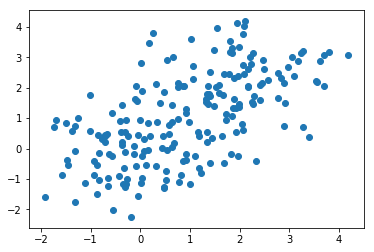

In [52]:
import matplotlib.pyplot as plt
import numpy as np
cluster1 = np.random.normal(0,1, (100, 2))
cluster2 = np.random.normal(2,1, (100, 2))
X = np.vstack((cluster1, cluster2))
print(X.shape)
plt.scatter(X[:,0],X[:,1])

Les questions posées par la classification sont : y a t-il un regroupement de ces données en 2 groupes qui soit optimal ? est il préférable de considérer 3 groupes, ou 4? 

### Algorithme des K-Moyennes

Les paramètres de cet algorithme sont les centres de gravité (centroid) des groupes constitués et l'assignation pour chacune des observations de son groupe. Ces paramètres sont trouvés en minimisant le **critère de la somme des inerties** qui est la somme des distances des observations au centre de gravité de la classe qui leur est assignée. Ce critère s'écrit:
$$J =  \sum_{k=1}^{K}\sum_{i \in C_k} \left\| x_i - \mu_k \right\|^2$$

Dans cette équation $C_k$ désigne le groupe (cluster) k, $\mu_k$ désigne le centre de gravité (appelé aussi centre d'inertie) du groupe k.
Pour le groupe k, $\sum_{i \in C_k} \left\| x_i - \mu_k \right\|^2$ désigne la somme des distances des observations assignées à ce groupe au centre de ce groupe et représente l'inertie de ce groupe. Plus cette inertie est grande plus le groupe est dipersé, plus elle est faible plus le groupe est compact.
L'algorithme des K-moyennes est un algorithme itératif qui minimise ce critère J. 

- Au départ, les centres sont initialisés à des valeurs arbitraires (aléatoires). En pratique on choisit comme centres initiaux K observations choisies au hasard.
- A chaque itération, l'algorithme :
  - assigne à chaque observation le groupe dont le centre est le plus proche de cette observation.
  - recalcule le centre d'inertie du groupe ainsi constitué.
  
Déroulons un petit exemple à la main.

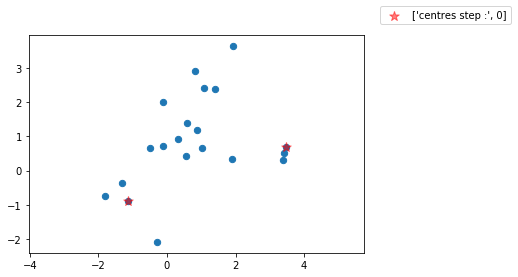

In [46]:
plt.scatter(X[:,0],X[:,1],s=40)
plt.axis('equal')
#Choisissons comme premiers centres deux points de la base au hasard
ind=np.random.randint(0,20,2)
mu=X[ind,:]
step=0
plt.scatter(mu[:,0],mu[:,1],c='r',marker='*',s=100,alpha=0.5,label=['centres step :', step])
plt.legend(loc=(1.05,1.05),scatterpoints = 1)
critere=np.zeros((10,))

Calculons les distances des observations à chacun de ces centres et choisissons pour chacune le centre le plus proche. Profitons en pour calculer l'inertie.Puis recalculons les centroides pour l'étape suivante.

critere de la somme des inerties :     27.64


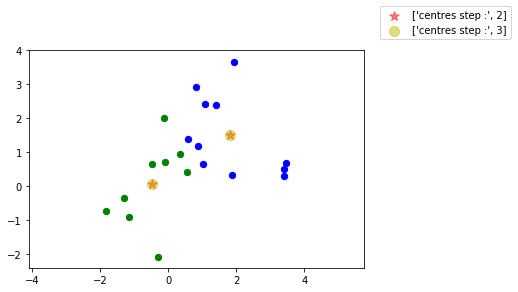

In [49]:
import numpy as np
import scipy.spatial.distance as scd
#1 : calcul des distances des observations aux centres
d=scd.cdist(X,mu)
#2 : choix du centre le plus proche: assignation de la classe de chaque observation
ass=np.argmin(d, axis=1)
#print(ass)
color=('g','b')
K=len(mu)
#3 : représentation des observations classées et calcul des inerties par classe
I=np.zeros((K,))
for k in range(K):
    plt.scatter(X[ass==k,0],X[ass==k,1],c=color[k],s=40)
    I[k]=np.sum(d[ass==k,k])#inertie de la classe k
critere[step]= np.sum(I)   
print('critere de la somme des inerties :{:10.2f}'.format(critere[step]))    
plt.axis('equal')
#représentation des centres initiaux
plt.scatter(mu[:,0],mu[:,1],c='r',marker='*',s=100,alpha=0.5,label=['centres step :', step])
#4 : re-calcul des centres des classes
mu_new=mu
step=step+1
for k in range(K):
    mu_new[k]=np.mean(X[ass==k,:],axis=0)
#représentation des centres finaux    
plt.scatter(mu[:,0],mu[:,1],c='y',marker='o',s=100,alpha=0.5,label=['centres step :', step])
plt.legend(loc=(1.05,1.05),scatterpoints = 1)
mu=mu_new  
#print(d)

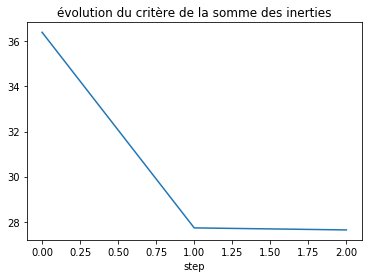

In [50]:
plt.plot(range(step),critere[0:step])
plt.title('évolution du critère de la somme des inerties')
plt.xlabel('step')

On peut maintenant utiliser la classe KMeans de scikit learn pour appliquer l'algorithme sur cette même base. Bien sur il n'y aura plus le bel affichage à chaque étape mais bon... on peut tout de même afficher le résultat final.

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 353.1048057491413
start iteration
done sorting
end inner loop
Iteration 1, inertia 325.55273114453826
start iteration
done sorting
end inner loop
Iteration 2, inertia 318.99390674424257
start iteration
done sorting
end inner loop
Iteration 3, inertia 316.061976116853
start iteration
done sorting
end inner loop
Iteration 4, inertia 315.7162820229624
start iteration
done sorting
end inner loop
Iteration 5, inertia 315.7162820229624
center shift 0.000000e+00 within tolerance 1.968665e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 333.10250624565504
start iteration
done sorting
end inner loop
Iteration 1, inertia 321.61029566697
start iteration
done sorting
end inner loop
Iteration 2, inertia 316.061976116853
start iteration
done sorting
end inner loop
Iteration 3, inertia 315.7162820229624
start iteration
done sorting
end inner loop
Iteration 4, inertia 31

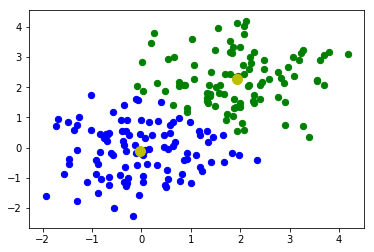

In [53]:
from sklearn.cluster import KMeans
clust=KMeans(n_clusters=2,n_init=5,verbose=1)
Ckm=clust.fit_predict(X) # pour obtenir les labels (n° classe) de chaque élément de la base
Xd=clust.transform(X) #pour avoir les distances de chaque élément aux centres des clusters
#affichage final de la base classée et des centres
for k in range(2):
    plt.scatter(X[Ckm==k,0],X[Ckm==k,1],c=color[k],s=40)
    I[k]=np.sum(Xd[Ckm==k,k])#inertie de la classe k
plt.scatter(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],c='y',marker='o',s=100)

print(I,sum(I))

Tout est identique au programme maison sauf le critère de la somme des inerties, bizarre, bizarre...

#### Problème des conditions initiales - Optimum local

On peut observer que l'évolution des centres et des classes varie avec le choix des centres initial. Il est certain que le critère décroit vers un minimum mais celui ci peut dans certains cas être un minimum local. Pour résoudre ce problème cet algorithme des K-moyennes est relancé plusieurs fois (de l'ordre de la dizaine ou même centaine de fois) avec des conditions initiales différentes (aléatoires). L'initialisation qui conduit au critère final minimum est retenue.

#### Problème du choix du nombre de classes - méthode du coude (elbow method)

Si K n'est pas spécifié par le contexte du problème il est important de pouvoir estimer le "meilleur" choix pour K.
Il est évident qu'à mesure que K croit le critère final de la somme des inerties J décroit (à la limite, si on choisit un nombre de classes K égal au nombre de données , le critère vaut 0). La méthode du coude consiste à repérer la valeur de K pour laquelle la courbe de décroissance de J forme un coude: avant cette valeur J décroit fortement à chaque incrément de K, après la décroissance est beaucoup plus faible.  K est  "optimal"  lorsque l'amélioration (la décroissance relative du critère) chute après cette valeur. Illustrons cette technique.

(800, 2)


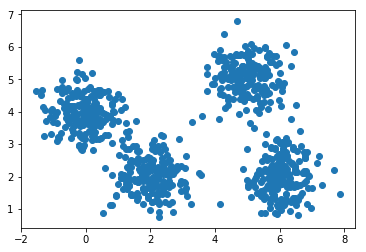

In [57]:
import numpy as np
sigma=0.55
x1 = np.random.normal(2,sigma, 200)
y1 = np.random.normal(2,sigma, 200)
x2 = np.random.normal(5,sigma, 200)
y2 = np.random.normal(5,sigma, 200)
x3 = np.random.normal(0,sigma, 200)
y3 = np.random.normal(4,sigma, 200)
x4 = np.random.normal(6,sigma, 200)
y4 = np.random.normal(2,sigma, 200)
x=np.hstack((x1,x2,x3,x4))
y=np.hstack((y1,y2,y3,y4))
X=np.vstack((x,y)).T
print(X.shape)
plt.scatter(X[:,0],X[:,1])

************************************
K =  1
Initialization complete
Iteration  0, inertia 14623.780
Iteration  1, inertia 6501.915
Converged at iteration 1: center shift 0.000000e+00 within tolerance 4.063697e-04
Initialization complete
Iteration  0, inertia 18423.453
Iteration  1, inertia 6501.915
Converged at iteration 1: center shift 0.000000e+00 within tolerance 4.063697e-04
Initialization complete
Iteration  0, inertia 17185.270
Iteration  1, inertia 6501.915
Converged at iteration 1: center shift 0.000000e+00 within tolerance 4.063697e-04
************************************
K =  2
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2327.091084217397
start iteration
done sorting
end inner loop
Iteration 1, inertia 2301.4614293288823
start iteration
done sorting
end inner loop
Iteration 2, inertia 2301.4614293288823
center shift 0.000000e+00 within tolerance 4.063697e-04
Initialization complete
start iteration
done sorting
end inner loop
Iterat

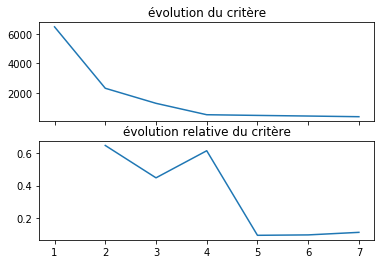

In [58]:
from sklearn.cluster import KMeans
J=np.zeros((8,))
for K in range(1,8):
    print('************************************')
    print('K = ',K)
    clust=KMeans(n_clusters=K,n_init=3,verbose=1)
    Ckm=clust.fit_predict(X)
    J[K]=clust.inertia_
    
f, axarr = plt.subplots(2, sharex=True)

axarr[0].plot(np.arange(1,8),J[1:8])  
axarr[0].set_title('évolution du critère')
axarr[1].plot(np.arange(2,8),(J[1:7]-J[2:8])/J[1:7])
axarr[1].set_title('évolution relative du critère')   

K=3 semble ici le meilleur choix du nombre de classes car le critère de la somme des inerties ne diminue plus de façon significative quand on passe de 3 à 4 groupes

#References

